# Neural Network

## Навигация

1. [Предобработка](#Предобработка)
1. [One-Hot Encoding модель](#One-Hot-Encoding-модель)
1. [train/val/test разбивка и конвертация из DataFame в Dataset](#train/val/test-разбивка-и-конвертация-из-DataFame-в-Dataset)
1. [Модель нейронной сети](#Модель-нейронной-сети)
1. [SHAP values](#SHAP-values)

In [1]:
RANDOM_STATE = 42

In [2]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', None)
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(RANDOM_STATE)

import src
from utils import visualization as viz

E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
E:\Projects\Breast-Cancer\venv\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_s

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [3]:
ETLED_DATA_PATH = os.path.join('..', 'data', 'etled', 'etled.csv')
NEURAL_NETWORK_MODEL_PATH = os.path.join('..', 'models', 'neural network')

TRAIN_SIZE = .7
VAL_SIZE = .2

LAYER_WIDTH = 64
BATCH_SIZE = 64
NUM_EPOCHS = 300

In [4]:
data = pd.read_csv(ETLED_DATA_PATH)

## Предобработка

[Навигация](#Навигация)

Масштабируем численные признаки:
- те, что имеют нормальное (Гаусово) распределение, стандартизируем
- другие нормализуем

In [5]:
def standanrdized(df, feature_name, *, fill_nan=0):
    """Возвращает df со стандартизированным столбцом feature_name."""
    df = df.copy()
    df.loc[df[feature_name].notna(), feature_name] = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()
    df.loc[df[feature_name].isna(), feature_name] = fill_nan
    return df

In [6]:
def normalized(df, feature_name, *, fill_nan=0):
    """Возвращает df с нормализованным столбцом feature_name."""
    df = df.copy()
    df.loc[df[feature_name].notna(), feature_name] = (df[feature_name] - df[feature_name].min()) / (df[feature_name].max() - df[feature_name].min())
    df.loc[df[feature_name].isna(), feature_name] = fill_nan
    return df

In [7]:
data = standanrdized(data, src.src.constants.QUESTION_2)
data = normalized(data, src.constants.QUESTION_4)
data = normalized(data, src.constants.QUESTION_22)
data = normalized(data, src.constants.QUESTION_24)

Кодируем бинарные признаки.

In [8]:
for feature in src.constants.BINARY_FEATURES:
    if data[feature].isna().sum():
        data[feature].replace({np.NaN: 0}, inplace=True)
    data[feature].replace({src.constants.YES: 1, src.constants.NO: 0}, inplace=True)

## One-Hot Encoding модель

[Навигация](#Навигация)

One-Hot Encoding категориальных и ранговых признаков.

In [9]:
def make_prefix(string):
    """Выделяет из названия признака только его номер."""
    prefix = ''.join(char for char in string if char.isdigit())
    if len(prefix) > 2:
        prefix = prefix[:2]
    return prefix

In [10]:
one_hot_df = data.copy()
for feature in list(src.constants.CATEGORICAL_FEATURES) + list(src.constants.RANK_FEATURES):
    prefix = make_prefix(feature)
    one_hot_df = pd.concat([one_hot_df, pd.get_dummies(one_hot_df[feature], prefix=prefix, drop_first=True)], axis=1).drop([feature], axis=1)

Переименую также и остальные столбцы.

In [11]:
for feature in src.constants.NUMERICAL_FEATURES + list(src.constants.BINARY_FEATURES):
    prefix = make_prefix(feature)
    one_hot_df.rename(columns={feature: prefix}, inplace=True)

## train/val/test разбивка и конвертация из DataFame в Dataset

[Навигация](#Навигация)

In [12]:
Y = one_hot_df[src.constants.TARGET]
X = one_hot_df.drop(src.constants.TARGET, axis=1).astype('float64')

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train,
    test_size=VAL_SIZE,
    stratify=Y_train,
    random_state=RANDOM_STATE,
)

In [14]:
print(f'Обучающая часть содержит {Y_train.shape[0]} точек данных.\n'
      f'Валидационная часть содержит {Y_val.shape[0]} точек данных.\n'
      f'Тестовая часть содержит {Y_test.shape[0]} точек данных.')

Обучающая часть содержит 332 точек данных.
Валидационная часть содержит 84 точек данных.
Тестовая часть содержит 179 точек данных.


In [15]:
true_labels = Y_test

In [16]:
Y_train = pd.get_dummies(Y_train, prefix=src.constants.TARGET)
Y_val = pd.get_dummies(Y_val, prefix=src.constants.TARGET)
Y_test = pd.get_dummies(Y_test, prefix=src.constants.TARGET)

## Модель нейронной сети

[Навигация](#Навигация)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(LAYER_WIDTH, activation='relu', input_shape=(101,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(LAYER_WIDTH, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax'),
])

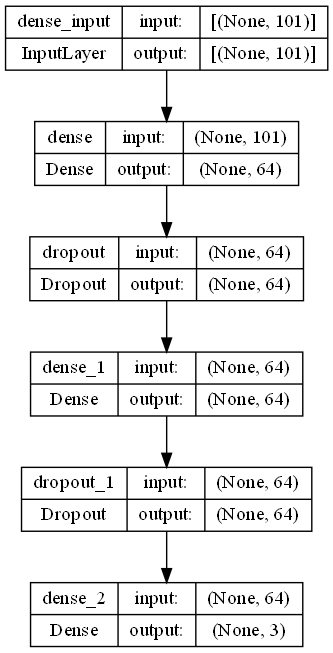

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB', dpi=100)

In [19]:
# Картинка встроена в jupyter notebook. Теперь удаляем файл, чтобы он не засорял проект.
os.remove('model.png')

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=NEURAL_NETWORK_MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
)
callbacks_list = [checkpoint]

history = model.fit(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=0,
    callbacks=callbacks_list,
    validation_data=(X_val, Y_val),
)

INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


INFO:tensorflow:Assets written to: ..\models\neural network\assets


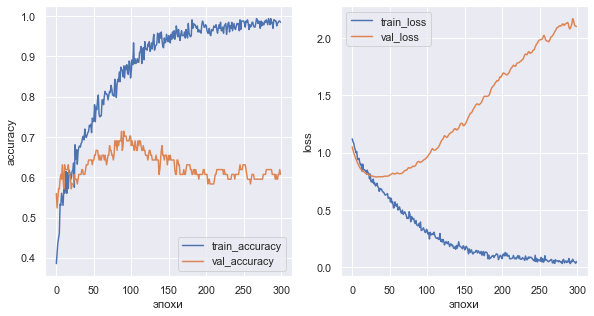

In [22]:
viz.plot_history(history, dpi=70)

In [23]:
model = tf.keras.models.load_model(NEURAL_NETWORK_MODEL_PATH)

6/6 [==============================] - 0s 4ms/step


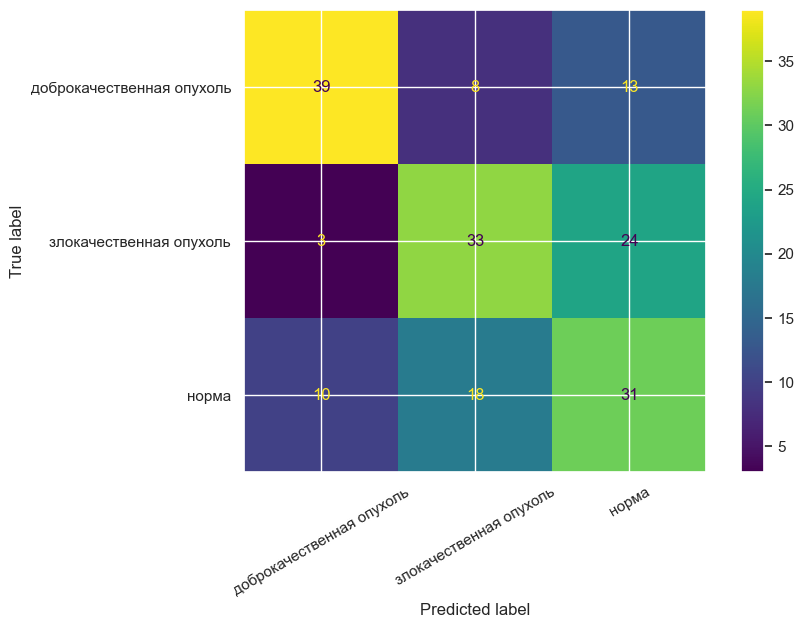

                           precision    recall  f1-score   support

доброкачественная опухоль       0.75      0.65      0.70        60
  злокачественная опухоль       0.56      0.55      0.55        60
                    норма       0.46      0.53      0.49        59

                 accuracy                           0.58       179
                macro avg       0.59      0.58      0.58       179
             weighted avg       0.59      0.58      0.58       179



In [24]:
pred_probabilities = model.predict(X_test)
pred_labels = []
for pred_probability in pred_probabilities:
    pred_label_index = np.array(pred_probability).argmax()
    pred_label = sorted(src.constants.LABELS)[pred_label_index]
    pred_labels.append(pred_label)
    
fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(true_labels, pred_labels))

## SHAP values

[Навигация](#Навигация)

In [25]:
background = X_train.iloc[np.random.choice(X_train.shape[0], 100, replace=False)]

In [26]:
explainer = shap.DeepExplainer(model, background.to_numpy())
shap_values = explainer.shap_values(X.to_numpy())

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


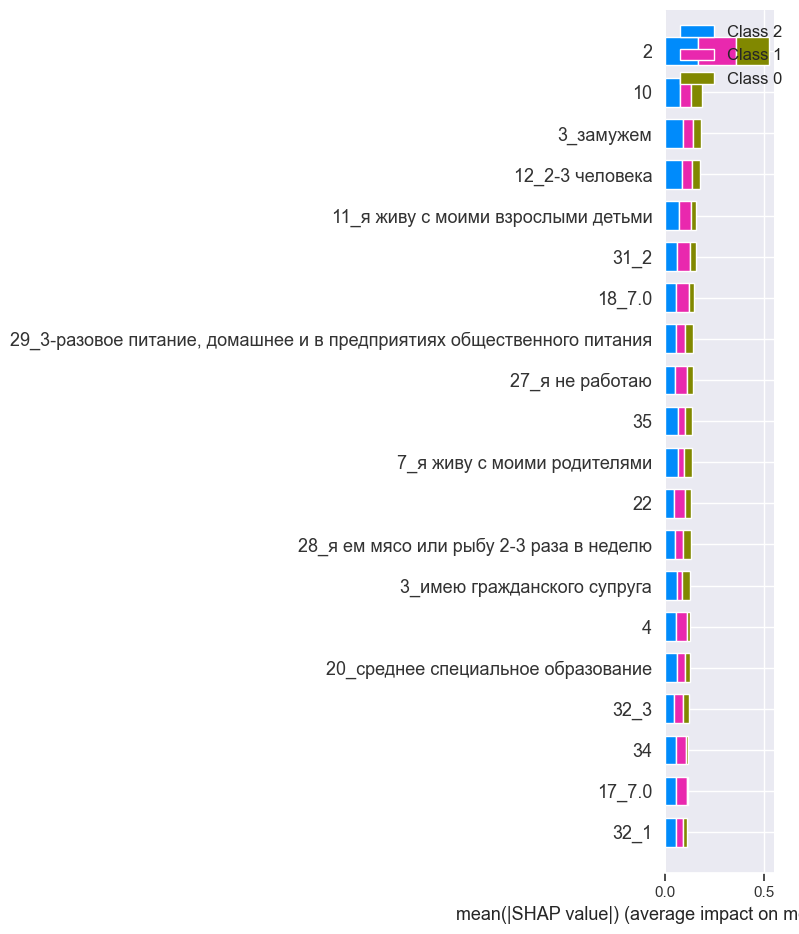

In [27]:
shap.summary_plot(shap_values, X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


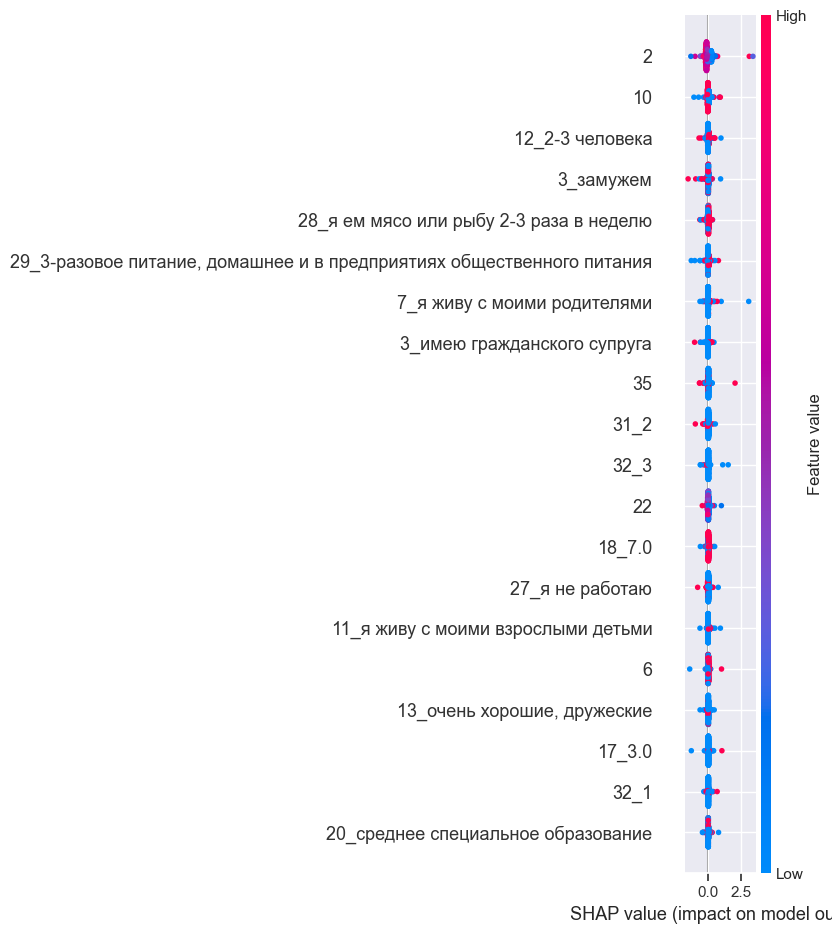

In [28]:
shap.summary_plot(shap_values[0], X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


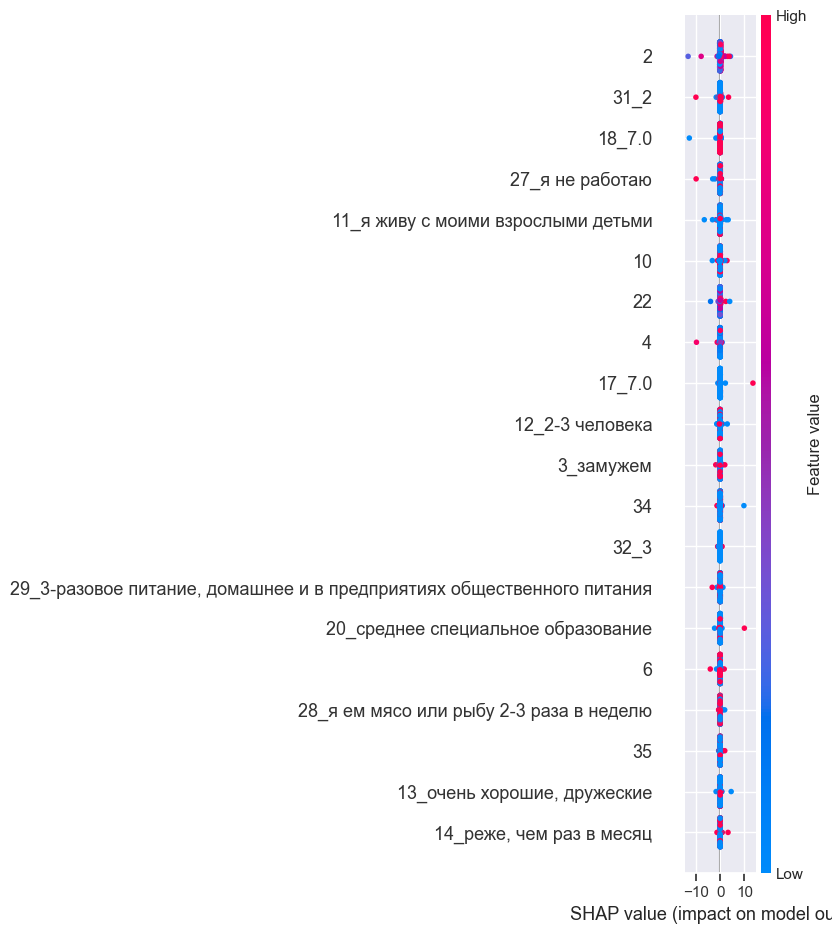

In [29]:
shap.summary_plot(shap_values[1], X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


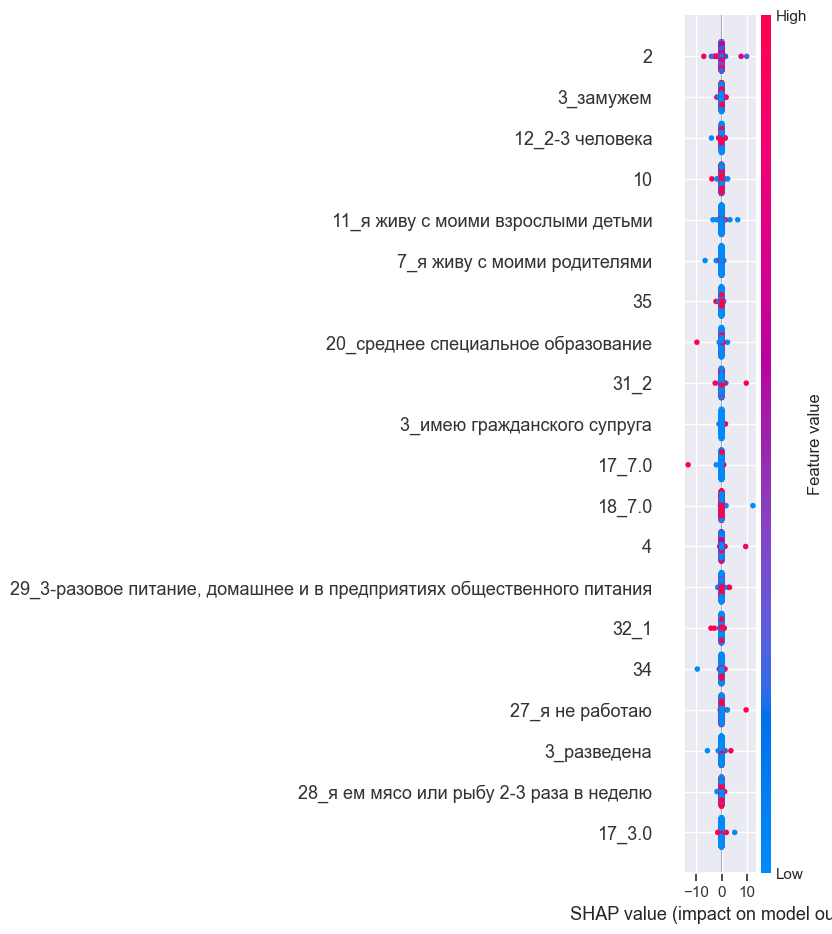

In [30]:
shap.summary_plot(shap_values[2], X)